In [ ]:
#vibo: Виталий_Бочаров_56089805 ТЕЛЕГРАММ @vibo22"

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#vibo: base_line подготовка датасета
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #vibo: загрузка датасета
    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #vibo: подготовка атрибутов
    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #vibo: подготовка фото
    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    
    #vibo: соотносим фото и атрибуты
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [ ]:
#vibo: импортируем библиотеки
import os
import pandas as pd
import skimage.io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from torchsummary import summary
from IPython.display import clear_output

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
#from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [ ]:
data.shape

(13143, 64, 64, 3)


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
#<тут Ваш код>

In [ ]:
#vibo: преобразуем данные к тензорам pytorch
data = torch.from_numpy(data)

In [ ]:
#vibo: количество фотографий в датасете
len(data)

13143

In [ ]:
#vibo: размер изображений 64*64, 3 канала
data.shape

torch.Size([13143, 64, 64, 3])

In [ ]:
#vibo: атрибуты фотографий, понадобятся в заключительном задании
attrs.head()

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.56835,-1.88904,1.7372,-0.929729,-1.4718,-0.19558,-0.835609,-0.351468,-1.01253,-0.719593,-0.632401,0.464839,-0.973528,1.56519,-1.2967,-1.54272,-0.684671,-0.86499,0.766886,-0.218952,-1.65567,-0.787044,-0.599665,0.458519,0.18976,0.851555,-0.38572,-0.497719,-0.161149,-0.257514,-0.0888388,0.455469,-0.839211,-0.0229481,-0.922568,-0.114539,1.46122,1.75848,0.0688935,1.26786,-1.12024,0.917617,-1.30796,-1.50041,1.02922,0.832363,-0.498657,0.251365,-0.705281,-0.515715,0.374239,-0.168675,-0.614143,3.0977,1.52386,0.779278,-0.0714539,-1.24648,-0.769283,-0.725597,-1.82061,-2.07298,-0.960759,0.361738,1.16612,-1.16492,-1.13999,-2.37175,-1.29993,-0.414682,-1.1449,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.28218,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,-0.736883,0.294554,-1.27765,0.954771,-0.990992,-1.16736,-0.835146,0.798544,-0.971679,0.342826,-1.32256,0.962937,-1.19936,-0.157307,0.443224,-0.00288156,-0.0211584,-0.226563,-0.0810386,-0.827202,-0.106624,1.22759,-0.812223,-1.24126,0.0962725,-0.404544,0.325919,0.474452,1.13536,0.0587247,0.611176,-1.17251,0.428512,-0.874235,-1.19156,0.192359,-0.204166,0.342347,0.239512,-1.47469,0.236057,-0.565208,-0.712542,2.99708,-0.273306,-0.187722,-0.604608,-1.3217,-0.938559,0.494294,-0.659043,-1.14375,-0.775722,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.00624408,-0.0304057,-0.480128,0.66676,-0.496559
2,0.997749,-1.36419,-0.157377,-0.756447,-1.89183,-0.871526,-0.862893,0.0314447,-1.34152,-0.0900375,-1.20073,-0.33246,-0.537006,1.29836,-1.49847,-1.28582,1.14174,0.172817,0.106412,-0.788843,0.349295,-1.64372,0.454287,1.18946,-0.688414,-0.590574,-0.266673,0.467224,0.567348,-1.7191,0.124667,1.60274,-0.659399,-1.75376,1.20447,0.0221884,-1.13544,1.70286,-0.422144,0.587859,0.414363,0.344447,-1.26045,-0.577746,0.405567,-1.91655,0.92126,0.247437,-0.428451,-0.772273,0.370673,-0.509596,-0.768482,1.7069,0.126524,-0.497001,-0.393042,-0.178307,-1.18023,-0.596914,-1.80538,-0.951643,-0.838087,1.54974,1.88475,-0.999765,-1.35986,-1.91211,-1.09563,0.915126,-0.572332,0.144262,-0.841231
3,1.12272,-1.9978,1.91614,-2.51421,-2.58007,-1.40424,0.0575511,0.000195882,-1.27351,-1.43146,-0.0705188,-0.339239,-2.00415,0.665695,-0.77594,-1.47163,-1.17908,0.563327,-0.664429,-1.40793,0.435594,-0.589988,-1.6035,1.17074,0.760103,0.211498,-0.51618,-1.33115,0.20284,0.149645,-0.0464296,0.640885,-0.107616,-0.831271,-0.827005,-0.588725,0.429255,1.58766,0.499086,-0.0568692,-0.866643,-0.959689,0.35073,-1.33535,-0.42789,0.826817,-0.256779,0.149751,-1.20153,-1.08392,0.255363,-0.650423,-0.506293,1.10159,0.640783,1.57503,-0.484397,-1.55968,-1.43712,0.379363,-0.648233,-2.25735,-1.07561,0.567822,-0.176089,1.10812,-1.60094,-3.26461,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.07821,-2.0081,1.67621,-2.27806,-2.65185,-1.34841,0.649089,0.0176564,-1.88911,-1.85721,-0.568057,0.840375,-1.98127,1.66671,-0.910723,-1.99351,-0.871335,0.507786,-0.488947,-0.88649,-0.990132,-0.750813,-0.378479,0.583086,-1.4796,0.250185,-0.381123,-0.611991,-0.143091,-1.07276,0.432094,1.08919,-0.470929,-1.17712,-0.111313,-0.154603,-1.03151,2.39246,-0.191576,1.2279,-1.3818,-1.52885,0.907964,-1.32429,-0

In [ ]:
#vibo: делим данные на трейн и валидацию
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs, train_size=0.9, shuffle=False)
train_loader = torch.utils.data.DataLoader(train_photos, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_photos, batch_size=32)

In [ ]:
#vibo: обучающий датасет 11828 изображений, размер 64*64, 3 канала rgb
train_photos.shape

torch.Size([11828, 64, 64, 3])

In [ ]:
#vibo: атрибуты обучающего датасета
train_attrs.head()

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.56835,-1.88904,1.7372,-0.929729,-1.4718,-0.19558,-0.835609,-0.351468,-1.01253,-0.719593,-0.632401,0.464839,-0.973528,1.56519,-1.2967,-1.54272,-0.684671,-0.86499,0.766886,-0.218952,-1.65567,-0.787044,-0.599665,0.458519,0.18976,0.851555,-0.38572,-0.497719,-0.161149,-0.257514,-0.0888388,0.455469,-0.839211,-0.0229481,-0.922568,-0.114539,1.46122,1.75848,0.0688935,1.26786,-1.12024,0.917617,-1.30796,-1.50041,1.02922,0.832363,-0.498657,0.251365,-0.705281,-0.515715,0.374239,-0.168675,-0.614143,3.0977,1.52386,0.779278,-0.0714539,-1.24648,-0.769283,-0.725597,-1.82061,-2.07298,-0.960759,0.361738,1.16612,-1.16492,-1.13999,-2.37175,-1.29993,-0.414682,-1.1449,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.28218,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,-0.736883,0.294554,-1.27765,0.954771,-0.990992,-1.16736,-0.835146,0.798544,-0.971679,0.342826,-1.32256,0.962937,-1.19936,-0.157307,0.443224,-0.00288156,-0.0211584,-0.226563,-0.0810386,-0.827202,-0.106624,1.22759,-0.812223,-1.24126,0.0962725,-0.404544,0.325919,0.474452,1.13536,0.0587247,0.611176,-1.17251,0.428512,-0.874235,-1.19156,0.192359,-0.204166,0.342347,0.239512,-1.47469,0.236057,-0.565208,-0.712542,2.99708,-0.273306,-0.187722,-0.604608,-1.3217,-0.938559,0.494294,-0.659043,-1.14375,-0.775722,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.00624408,-0.0304057,-0.480128,0.66676,-0.496559
2,0.997749,-1.36419,-0.157377,-0.756447,-1.89183,-0.871526,-0.862893,0.0314447,-1.34152,-0.0900375,-1.20073,-0.33246,-0.537006,1.29836,-1.49847,-1.28582,1.14174,0.172817,0.106412,-0.788843,0.349295,-1.64372,0.454287,1.18946,-0.688414,-0.590574,-0.266673,0.467224,0.567348,-1.7191,0.124667,1.60274,-0.659399,-1.75376,1.20447,0.0221884,-1.13544,1.70286,-0.422144,0.587859,0.414363,0.344447,-1.26045,-0.577746,0.405567,-1.91655,0.92126,0.247437,-0.428451,-0.772273,0.370673,-0.509596,-0.768482,1.7069,0.126524,-0.497001,-0.393042,-0.178307,-1.18023,-0.596914,-1.80538,-0.951643,-0.838087,1.54974,1.88475,-0.999765,-1.35986,-1.91211,-1.09563,0.915126,-0.572332,0.144262,-0.841231
3,1.12272,-1.9978,1.91614,-2.51421,-2.58007,-1.40424,0.0575511,0.000195882,-1.27351,-1.43146,-0.0705188,-0.339239,-2.00415,0.665695,-0.77594,-1.47163,-1.17908,0.563327,-0.664429,-1.40793,0.435594,-0.589988,-1.6035,1.17074,0.760103,0.211498,-0.51618,-1.33115,0.20284,0.149645,-0.0464296,0.640885,-0.107616,-0.831271,-0.827005,-0.588725,0.429255,1.58766,0.499086,-0.0568692,-0.866643,-0.959689,0.35073,-1.33535,-0.42789,0.826817,-0.256779,0.149751,-1.20153,-1.08392,0.255363,-0.650423,-0.506293,1.10159,0.640783,1.57503,-0.484397,-1.55968,-1.43712,0.379363,-0.648233,-2.25735,-1.07561,0.567822,-0.176089,1.10812,-1.60094,-3.26461,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.07821,-2.0081,1.67621,-2.27806,-2.65185,-1.34841,0.649089,0.0176564,-1.88911,-1.85721,-0.568057,0.840375,-1.98127,1.66671,-0.910723,-1.99351,-0.871335,0.507786,-0.488947,-0.88649,-0.990132,-0.750813,-0.378479,0.583086,-1.4796,0.250185,-0.381123,-0.611991,-0.143091,-1.07276,0.432094,1.08919,-0.470929,-1.17712,-0.111313,-0.154603,-1.03151,2.39246,-0.191576,1.2279,-1.3818,-1.52885,0.907964,-1.32429,-0

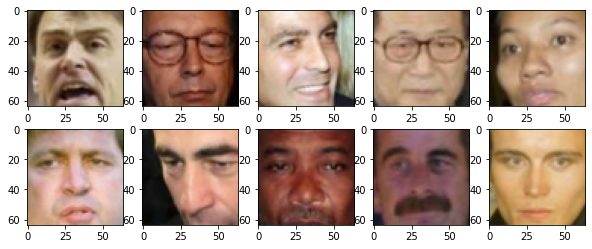

In [ ]:
#vibo: несколько фотографий из обучающего датасета
fig=plt.figure(figsize=(10, 4))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    img = train_photos[int(np.random.uniform(0,len(train_photos)))].permute(0, 1, 2)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [ ]:
#vibo: валидационный датасет, 1315 изображений, 64*64, 3 канала
val_photos.shape

torch.Size([1315, 64, 64, 3])

In [ ]:
#vibo: атрибуты валиационного датасета
val_attrs.head()

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
11828,-0.171545,-0.785678,-0.308916,-1.27813,-0.897135,-0.77435,-0.501739,-0.411599,-0.829738,-0.485207,-0.44336,-0.0517876,-1.95072,-1.22503,-1.30658,0.816113,-0.506315,0.0751386,-0.108076,-0.842532,-0.990017,4.41694,-0.8395,-5.49911,0.575335,0.547031,0.270612,-1.13084,-0.521027,-0.465455,-0.31272,-0.282975,-0.18148,-0.451844,0.151735,-0.883176,-0.385795,0.191012,0.766864,0.292116,-0.181305,-1.32891,0.314246,-0.0602161,-0.652462,0.42775,-0.963156,0.298648,-0.415268,-0.887727,0.0424914,-0.593694,-0.361118,4.69287,-0.206562,0.100817,-0.342048,-0.771969,-0.92835,-0.210022,-0.457907,-4.73785,-0.606649,-0.709865,-1.46824,0.74441,-0.292664,-2.21461,0.0375744,2.05936,-0.364628,0.104375,0.228107
11829,0.575667,-1.02169,0.737665,-2.88619,-1.61322,-1.09185,-0.216397,-0.492347,-0.6256,-0.0370769,-0.795414,-0.0863948,-1.38837,0.774032,-1.14869,-0.843613,-1.06785,0.131063,0.105146,0.779909,0.00142826,0.00465995,-0.744148,0.767955,-0.348094,0.518194,-0.976931,0.56436,-0.926518,-1.10303,-0.621215,1.29606,-0.543645,-0.795715,-0.0746002,0.152547,-1.23069,2.24223,0.531535,0.0409045,-0.33441,0.851964,0.180863,-1.66395,-0.324565,0.925937,-0.381854,0.33181,-0.0118697,0.0884293,-0.333564,-0.238268,-0.232868,3.05904,0.561139,-0.486648,-0.832715,-1.08157,-0.534592,0.634479,-0.752505,-1.69937,-0.946929,-1.97381,-0.496265,0.56005,-0.0985509,-2.68281,0.577652,0.899423,-0.237633,0.302092,-0.161563
11830,0.843254,-1.88364,1.14721,-1.54428,-1.44175,-0.704055,-0.571218,-0.337027,-0.517829,-0.101664,-0.550052,-0.509189,-1.2467,1.8647,-0.853556,-1.81614,-0.829479,0.21979,-0.100599,0.130255,-0.162714,-0.390739,0.172023,-0.262034,-0.763089,-0.0475357,-0.651804,-0.386259,0.909947,-1.15322,-0.138941,0.37467,-1.38766,-1.00579,-0.0951574,-1.09217,0.0788063,0.796789,0.700181,0.626696,-0.326379,-1.03592,0.586656,-1.49662,-0.658418,0.611576,-0.630928,0.174049,-0.279565,-1.27344,0.649585,-0.137188,-0.903055,4.02035,0.0528167,-0.113548,-0.717306,-1.1906,-0.656306,-0.752276,-0.700519,0.0877111,-0.247108,-0.193732,0.331655,0.142152,-1.31266,0.148699,0.102983,-0.442047,-0.625762,0.505649,-0.627941
11831,-0.431737,-0.21472,0.139237,-0.806859,-1.47357,-1.3136,0.278121,-0.737519,-0.435204,-1.13755,-0.609746,0.508535,-1.51091,0.95983,-1.38752,-1.30955,-0.432702,0.678221,-0.620299,0.202478,0.200526,-0.291621,-0.469607,0.678498,0.0454255,-0.509792,-0.205537,-0.445291,0.248878,-0.258761,-0.108803,-1.02949,-0.633552,-0.308215,-0.662957,0.404492,-0.219998,1.65681,1.23667,0.735361,-0.52755,-0.0489169,0.0370184,-1.23202,-0.665394,0.408695,-0.838876,0.310532,-0.17722,-0.819568,-0.00884185,-0.768701,-0.560168,4.84593,-1.87868,0.141812,0.102939,-1.31765,-0.0375803,-0.208808,0.0822221,0.695879,-0.42584,-1.25372,-0.408485,0.873217,0.227973,-0.842252,0.663957,1.72833,-0.066853,-0.502723,-0.18787
11832,-1.99682,-1.60494,1.29967,-2.687,-2.17683,-1.15312,0.299671,-0.545456,-1.31693,-1.51876,-1.2781,1.60184,-1.73326,2.16216,-1.93865,-2.07704,-1.44029,1.13149,-1.29826,-1.17858,-0.819564,-1.84686,-0.378335,1.7478,-0.938875,-1.04605,0.588672,0.267711,-1.21812,-1.1884,-0.434776,1.12916,-0.696049,-1.72997,-1.05793,-0.521549,-0.205505,1.83669,0.

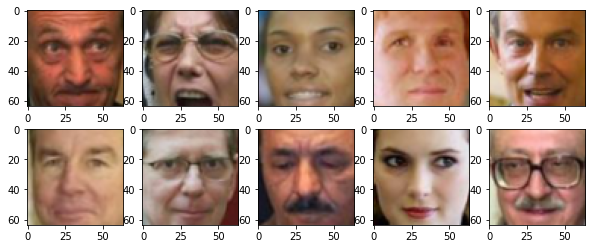

In [ ]:
#vibo: несколько фотографий из валидационного датасета
fig=plt.figure(figsize=(10, 4))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    img = val_photos[int(np.random.uniform(0,len(val_photos)))].permute(0, 1, 2)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
# dim_code = <your code here> # выберите размер латентного вектора

#vibo: размер латентного вектора
dim_code = 64

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
# from copy import deepcopy

# class Autoencoder(nn.Module):
#     def __init__(self):
#         <определите архитектуры encoder и decoder>
        
#     def forward(self, x):
        
#         <реализуйте forward проход автоэнкодера
#         в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code) 
#         и полученная реконструкция изображения (reconstruction)>
        
#         return reconstruction, latent_code

In [ ]:
#vibo: реализуем класс автоэнкодера

from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.flatten = nn.Flatten()
        
        #vibo: делаем encoder        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=64*64*3, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),                    
            #vibo: out_features=dim_code
            nn.Linear(in_features=512, out_features=dim_code)
        )
 
        #vibo: делаем decoder 
        self.decoder = nn.Sequential(
            #vibo: in_features=dim_code
            nn.Linear(in_features=dim_code, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=1024),
            nn.ReLU(),                    
            nn.Linear(in_features=1024, out_features=64*64*3),
        )     

    def forward(self, x):
        #vibo: перед заходом в encoder картинку нужно расплющить
        x = self.flatten(x).float()
        #vibo: пропускаем картинку через encoder, получаем латентное представление    
        latent_code = self.encoder(x).view(-1, 1, dim_code)
 
        #vibo: проходим через decoder, получаем реконструированное изображение
        reconstruction = self.decoder(latent_code)
        
        #vibo: возвращаем реконструированное изображение и латентное представление изображений
        return reconstruction, latent_code

In [ ]:
#vibo: перенос на GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
#vibo: проверяем модель
autoencoder = Autoencoder().to(device)
summary(autoencoder, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 12288]               0
            Linear-2                 [-1, 1024]      12,583,936
              ReLU-3                 [-1, 1024]               0
            Linear-4                  [-1, 512]         524,800
              ReLU-5                  [-1, 512]               0
            Linear-6                   [-1, 64]          32,832
            Linear-7               [-1, 1, 512]          33,280
              ReLU-8               [-1, 1, 512]               0
            Linear-9              [-1, 1, 1024]         525,312
             ReLU-10              [-1, 1, 1024]               0
           Linear-11             [-1, 1, 12288]      12,595,200
Total params: 26,295,360
Trainable params: 26,295,360
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Fo

In [ ]:
#vibo: реализуем другой автоэнкодер (сверточный)
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
       
        #vibo: делаем encoder        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),                                            
            #vibo: out_features=dim_code
            nn.Conv2d(in_channels=512, out_channels=dim_code, kernel_size=3, padding=1)
        )
 
        #vibo: делаем decoder 
        self.decoder = nn.Sequential(
            #vibo: in_features=dim_code
            nn.Conv2d(in_channels=dim_code, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, padding=1)
        )     

    def forward(self, x):
        #vibo: пропускаем картинку через encoder, получаем латентное представление
        #vibo: encoder ждет на вход [размер_батча, 3, 64, 64]
        #vibo: из даталоадера на вход попадает тензор формата [размер-батча, 64, 64, 3]
        latent_code = self.encoder(x)
 
        #vibo: проходим через decoder, получаем реконструированное изображение
        reconstruction = self.decoder(latent_code)
        
        #vibo: возвращаем реконструированное изображение и латентное представление изображений
        return reconstruction, latent_code

In [ ]:
#vibo: перенос на GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
#vibo: проверяем модель
autoencoder = Autoencoder().to(device)
summary(autoencoder, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]          73,856
              ReLU-4          [-1, 128, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]         147,584
              ReLU-6          [-1, 128, 32, 32]               0
            Conv2d-7          [-1, 256, 16, 16]         295,168
              ReLU-8          [-1, 256, 16, 16]               0
            Conv2d-9          [-1, 256, 16, 16]         590,080
             ReLU-10          [-1, 256, 16, 16]               0
           Conv2d-11            [-1, 512, 8, 8]       1,180,160
             ReLU-12            [-1, 512, 8, 8]               0
           Conv2d-13            [-1, 512, 8, 8]       2,359,808
           Conv2d-14            [-1, 51

In [ ]:
device

'cuda:0'

In [ ]:
# criterion = <loss>

# autoencoder = Autoencoder()

# optimizer = <Ваш любимый оптимизатор>

In [ ]:
#vibo: функция ошибки MSE
criterion = F.mse_loss
#vibo: модель с переносом на device
autoencoder = Autoencoder().to(device)
#vibo: оптимайзер Адам, lr=3e-4
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=3e-4)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
#<тут Ваш код тренировки автоэнкодера>

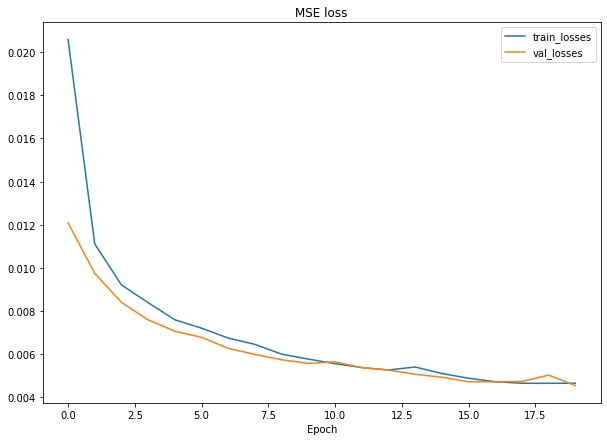

In [ ]:
#vibo: реализуем цикл обучения автоэнкодера
n_epochs = 20
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for train_batch in train_loader:
        optimizer.zero_grad()
        train_reconstruction, train_latent_code = autoencoder(train_batch.to(device))
        train_reconstruction = train_reconstruction.view(-1, 64, 64, 3)
        train_loss = criterion(train_batch.to(device).float(), train_reconstruction)
        train_loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(train_loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for val_batch in val_loader: 
          val_reconstruction, val_latent_code = autoencoder(val_batch.to(device))
          val_reconstruction = val_reconstruction.view(-1, 64, 64, 3)
          val_loss = criterion(val_batch.to(device).float(), val_reconstruction)
          val_losses_per_epoch.append(val_loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

    #vibo: визуализируем loss
    clear_output(wait=True)
    plt.figure(figsize=(10, 7))
    plt.plot(np.arange(len(train_losses)), train_losses, label='train_losses')
    plt.plot(np.arange(len(val_losses)), val_losses, label='val_losses')

    plt.xlabel('Epoch')
    plt.title('MSE loss')
    plt.legend()
    plt.show()

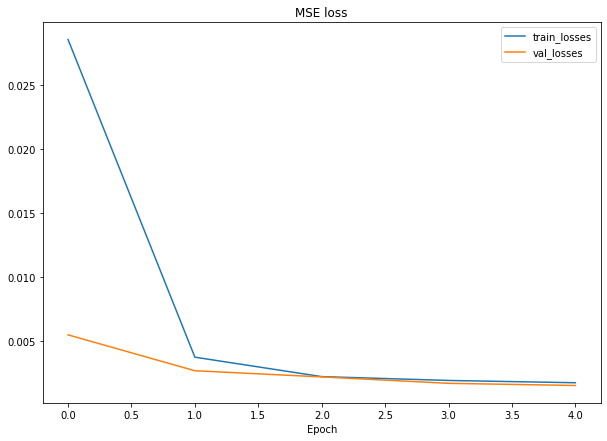

In [ ]:
#vibo: реализуем другой цикл обучения для сверточного автоэнкодера
n_epochs = 5
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for train_batch in train_loader:
        optimizer.zero_grad()
        #vibo: из даталоадера на вход попадает тензор формата [размер-батча, 64, 64, 3]
        #vibo: encoder ждет на вход [размер_батча, 3, 64, 64]
        #vibo: меняем местами столбцы тензора
        train_batch = torch.permute(train_batch, (0, 3, 1, 2)).float()
        train_reconstruction, train_latent_code = autoencoder(train_batch.to(device))
        train_loss = criterion(train_batch.to(device).float(), train_reconstruction)
        train_loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(train_loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for val_batch in val_loader:
          #vibo: из даталоадера на вход попадает тензор формата [размер-батча, 64, 64, 3]
          #vibo: encoder ждет на вход [размер_батча, 3, 64, 64]
          #vibo: меняем местами столбцы тензора
          val_batch = torch.permute(val_batch, (0, 3, 1, 2)).float() 
          val_reconstruction, val_latent_code = autoencoder(val_batch.to(device))
          val_loss = criterion(val_batch.to(device).float(), val_reconstruction)
          val_losses_per_epoch.append(val_loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

    #vibo: визуализируем loss
    clear_output(wait=True)
    plt.figure(figsize=(10, 7))
    plt.plot(np.arange(len(train_losses)), train_losses, label='train_losses')
    plt.plot(np.arange(len(val_losses)), val_losses, label='val_losses')

    plt.xlabel('Epoch')
    plt.title('MSE loss')
    plt.legend()
    plt.show()

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
#< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>

In [ ]:
autoencoder.eval()
with torch.no_grad():
    for val_batch in val_loader:
      val_reconstruction, val_latent_code = autoencoder(val_batch.to(device))
      val_reconstruction = val_reconstruction.view(-1, 64, 64, 3)
      result = val_reconstruction.cpu().detach().numpy()
      ground_truth = val_batch.numpy()
      break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


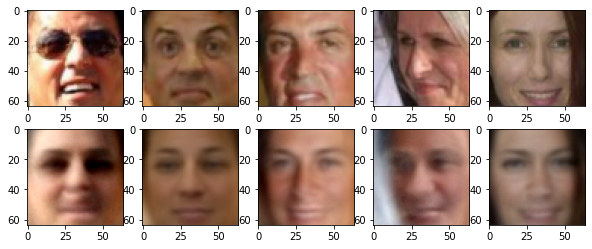

In [ ]:
plt.figure(figsize=(10, 4))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(2, 5, i+1)
  plt.imshow(gt)
  plt.subplot(2, 5, i+6)
  plt.imshow(res)

In [ ]:
#vibo: сравним результаты, выведем изображения восстановленные сверточным автоэнкодером
autoencoder.eval()
with torch.no_grad():
    for val_batch in val_loader:
      val_batch = torch.permute(val_batch, (0, 3, 1, 2)).float() 
      val_reconstruction, val_latent_code = autoencoder(val_batch.to(device))
      val_reconstruction = torch.permute(val_reconstruction, (0, 2, 3, 1))
      result = val_reconstruction.cpu().detach().numpy()
      val_batch = torch.permute(val_batch, (0, 2, 3, 1))
      ground_truth = val_batch.numpy()
      break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


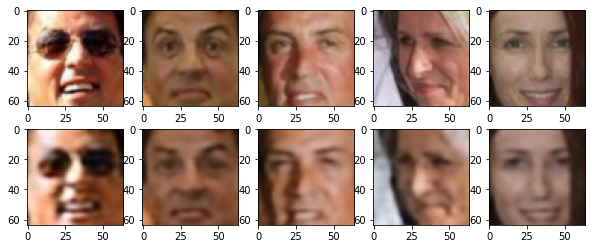

In [ ]:
plt.figure(figsize=(10, 4))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(2, 5, i+1)
  plt.imshow(gt)
  plt.subplot(2, 5, i+6)
  plt.imshow(res)

Not bad, right? 

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:
# # сгенерируем 25 рандомных векторов размера latent_space
# z = np.random.randn(25, <latent_space_dim>)
# output = <скормите z декодеру>
# <выведите тут полученные картинки>

In [ ]:
#vibo: генерируем 25 случайных векторов размерности латентного пространства
z = np.random.randn(25, dim_code)
#vibo: декодируем случайные вектора
output = autoencoder.decoder(torch.FloatTensor(z).to(device))
output = output.view(-1, 64, 64, 3)
output = output.cpu().detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

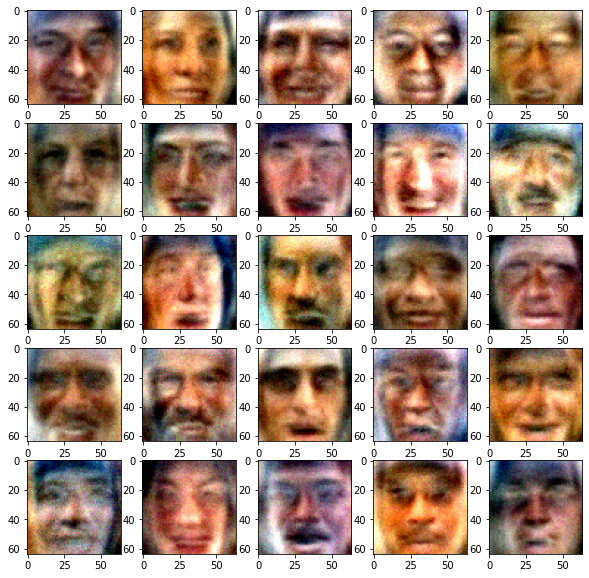

In [ ]:
fig=plt.figure(figsize=(10, 10))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = output[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
#<ваш код здесь>

In [ ]:
happy_photos = attrs.sort_values(by='Smiling').tail(15).index

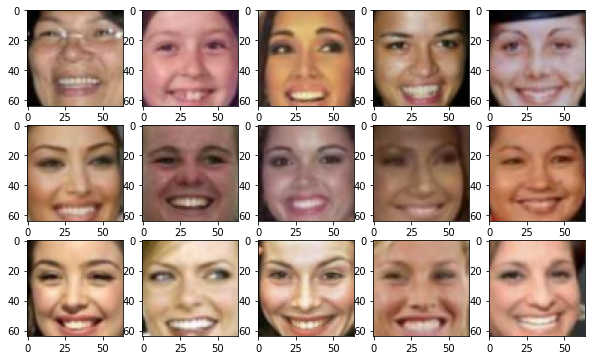

In [ ]:
#vibo: 15 фотографий c улыбками
fig=plt.figure(figsize=(10, 6))
columns = 5
rows = 3
for i in range(1, columns*rows +1):
    img = data[happy_photos][i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [ ]:
#vibo: данные в тензорх pytorch
happy_photos = data[happy_photos]
happy_photos.shape

torch.Size([15, 64, 64, 3])

In [ ]:
#vibo: получаем латентное представление людей с улыбками
out = autoencoder.flatten(happy_photos.to(device)).float()
latent_code_smile = autoencoder.encoder(out).view(-1, 1, dim_code)
latent_code_smile.shape

torch.Size([15, 1, 1024])

In [ ]:
#vibo: средний вектор людей с улыбками
mean_latent_code_smile = torch.mean(latent_code_smile, 0)
mean_latent_code_smile.shape

torch.Size([1, 1024])

In [ ]:
#vibo: женщины - грустные -
w = attrs.sort_values(by=['Male'], ascending=[True])

In [ ]:
w[:100]

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
9721,-3.67287,-1.47538,0.342252,-2.21041,-2.05933,-0.573577,1.31891,-0.764608,-1.5616,0.00629372,-0.952922,1.24534,-1.80242,1.67402,-2.28104,-1.42076,-1.73908,1.9822,-1.77616,-0.671173,-0.384549,-1.53217,-1.47493,1.15705,1.06472,-1.04975,0.774236,0.596157,-1.70019,-1.46175,-1.15799,1.46382,-1.12504,-1.13687,-1.68491,0.459538,-0.636157,1.39305,-0.178795,0.628582,0.075732,-2.01,0.707668,-0.928953,-0.986656,1.75993,-1.5157,0.814426,-1.14045,-1.51183,1.23847,-1.24912,-0.542245,7.49828,0.121926,0.910527,0.854045,-1.13083,-1.50996,-0.0907405,0.436853,1.63007,-0.904605,-1.7431,-2.07225,1.25792,1.11649,1.46066,0.515089,0.203421,1.04308,-1.53656,1.28084
8785,-3.51565,-2.28334,2.31219,-2.89218,-2.13563,-1.54466,-0.48855,0.415033,-1.40357,-1.11316,-0.724601,1.30818,-2.33317,2.02287,-1.80063,-1.80012,-1.80585,1.50706,-1.5416,-1.58013,-0.263322,-1.11536,0.294049,0.66095,0.0846115,0.213112,0.856955,-1.73557,-1.73775,-1.98452,-1.06594,1.54355,-1.3928,-1.85517,-1.67719,0.317732,-0.407452,1.28874,-0.860766,0.92515,-0.160899,-1.2261,0.468037,-0.937095,-0.9729,1.82663,-1.14935,0.359302,-0.293077,-1.47042,1.376,-0.811752,-0.845329,2.26808,0.206414,0.415804,0.56476,-1.14627,-1.57226,-1.16352,2.021,1.04438,-0.564479,2.14863,-1.45567,0.411598,2.09041,-0.97458,1.07685,-2.00457,1.23875,-0.722645,1.14154
492,-3.42514,-1.69676,0.590839,-2.14753,-2.85453,-1.21624,0.760346,-0.100427,-2.01993,-0.357667,-0.861926,-0.116408,-2.09087,1.80663,-1.57127,-1.37643,-1.86753,2.12308,-2.04801,-0.947013,0.180353,-1.5808,-1.16497,1.135,1.5026,-1.60043,0.15759,0.431966,-3.14004,-1.80904,-0.977881,-1.07504,0.548655,-1.26926,-1.16957,0.957911,-0.0847181,1.44932,-0.167607,0.444594,0.0728097,-1.05427,1.20598,-1.69356,-1.67262,2.92383,-1.09545,0.518046,-1.62907,-1.43762,1.05939,-0.820881,-0.461605,1.16165,1.07917,0.771231,1.20316,-0.143356,-1.73506,-0.531031,1.27167,-0.67558,-0.566416,2.12366,-1.88274,1.19174,2.08291,-1.45575,0.988604,-1.57488,1.05921,-1.32352,1.66655
2095,-3.41081,-1.3423,0.857155,-1.86473,-2.28971,-0.170307,-0.220125,-0.526789,-1.89087,-1.29823,0.439621,0.472004,-1.65846,2.30093,-2.55102,-1.23346,-2.01107,0.980767,-1.21214,-1.74752,-0.784655,-1.79406,-0.828118,1.02692,0.435935,-1.15871,1.13179,-1.32097,-2.04519,-0.971326,-1.47405,1.80236,-0.883927,-1.5239,-2.3121,0.985172,-1.45807,1.62208,-1.28853,0.314117,0.12888,-0.766215,1.14647,-1.28443,-0.654216,2.21432,-1.65058,0.597346,-0.962347,-2.19351,0.587304,-1.07857,-0.4063,5.03592,1.3468,0.408535,1.35286,-1.46684,-1.42231,-1.00289,2.07181,2.19505,-0.613761,0.257325,-2.188,0.140139,2.53152,0.708895,1.02434,-0.567442,1.30121,-1.38812,1.26901
2031,-3.26303,-0.879805,0.0440714,-1.47302,-1.80201,-1.5619,1.42995,-0.612242,-1.95587,-0.278732,-0.455376,0.0137066,-1.86358,1.94244,-2.15404,-1.49907,-2.09547,2.67085,-2.41548,-1.22035,0.2658,-1.45252,-0.61166,1.41657,0.625221,-0.9162,-0.0969437,-0.117129,-2.20551,-1.53945,-1.66745,1.52103,-0.811383,-0.783965,-1.56965,1.56458,1.36055,1.29601,-0.542553,0.34064,0.578134,-2.19538,1.65371,-1.07816,-1.89623,2.71234,-1.86567,0.838715,-1.54408,0.775895,1.27153,-1.2306,-0.123769,3.38914,1.20656,0.684998,1.55675,-1.07097,-1.728

In [ ]:
w = w[:100].sort_values(by=['Smiling'], ascending=[True])

In [ ]:
w

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
7676,-2.70478,-2.27563,2.24845,-2.32862,-2.10815,-0.782742,-0.0631338,-0.60127,-1.777,-1.87794,0.156684,-0.478406,-1.65372,2.05746,-1.50268,-2.07769,-1.90702,-1.43403,1.36675,0.151223,-1.21727,-1.27365,-0.0298694,1.09356,-0.811436,-0.944069,0.991073,-0.910873,-1.34026,-2.32249,-1.3721,0.520416,-0.776252,-2.08534,-1.6608,0.175738,-1.06542,2.8156,-1.03,1.39189,0.130161,1.04261,-1.33725,-1.91362,1.16984,1.41996,-0.677953,0.0334468,-0.349238,-0.845436,0.364272,-0.798073,-0.701681,2.39383,1.01458,0.290134,0.946107,-1.49666,-0.630607,-1.07521,1.36881,-0.291153,-0.974166,2.19665,-0.872259,-1.55037,1.21387,-2.123,-0.449551,-2.52161,0.675637,-1.09087,0.366802
10180,-2.57046,-0.714644,0.072119,-1.96717,-1.59754,-0.0717418,0.757237,-1.08868,-1.53539,-1.11417,-0.439585,1.23491,-2.38531,2.05009,-1.49945,-2.05408,-1.53434,-1.15372,1.21719,-1.9821,0.171378,-0.906351,-0.74402,0.697395,-0.856756,-0.355367,0.238569,0.56953,-2.13553,-2.17669,-0.664178,1.48017,-0.642081,-2.05615,-1.73013,0.451282,1.85873,0.30625,-0.975707,1.22875,0.630894,1.21211,-1.08816,-0.688816,1.0088,1.36672,-0.898139,0.177069,-1.13484,-1.36026,1.89195,-1.64608,-0.862775,3.63518,0.0979638,0.906163,0.930441,-1.22923,-1.60306,-1.297,1.34287,-3.06165,-0.590845,-1.28879,-1.40916,-1.72751,1.39969,-5.40555,-0.657221,1.18472,0.109632,-0.371553,0.00184551
9143,-2.80989,-2.64535,2.13974,-3.35714,-0.659513,-0.653499,-0.864982,-0.49044,-1.19602,-1.8872,0.522982,-0.226185,-2.21577,2.31818,-1.70945,-1.10345,-1.79116,-0.937978,1.25015,0.4249,-0.000653685,-1.4472,-1.37035,1.66137,-0.293286,0.0710214,0.535613,-2.06739,-2.55586,-2.40528,-0.692948,0.119213,-0.753801,-1.36333,-1.80806,0.918959,-0.609115,1.70984,-2.18168,1.00561,-1.73433,0.464798,-0.940497,-0.642918,1.32694,1.33742,-0.688643,0.455836,-0.684987,-1.47553,0.606456,-0.700641,-0.227443,1.10946,0.918916,0.103168,0.130135,-1.77451,-1.89146,-0.870126,0.553174,-2.18936,-1.77666,0.659802,-0.906968,-0.745664,0.412731,-3.70015,0.413443,-0.0178169,0.877992,0.0971829,-0.168198
10291,-2.96304,-2.47062,1.25471,-1.76141,-1.57367,-0.394055,0.0247827,-0.97076,-1.04243,-1.53169,0.554236,0.762658,-2.19824,1.66763,-1.4123,-1.22625,-1.68665,-0.70036,0.511187,-1.67043,-1.07764,-1.32097,-0.513009,1.46227,-1.67806,-0.462096,1.81468,-1.29022,-2.30017,-1.36062,-1.09142,0.624283,-0.730501,-1.84785,-1.86477,1.01149,-1.63163,2.58547,-1.2443,1.47335,0.724103,0.271155,-1.09913,-0.616516,0.262807,2.18923,-1.35587,0.225606,-0.993771,-2.08514,1.44804,-0.864915,-1.09516,4.24092,1.81102,0.180765,1.90553,-0.706515,-1.283,-1.07415,2.36076,0.677779,0.792056,-0.0719405,-2.112,-1.04161,2.33422,-0.809385,0.445176,-1.46602,0.923131,-0.868339,0.560322
8991,-2.89404,-1.2609,0.0816416,-2.61211,0.718852,-0.843924,-0.309156,-0.724927,-2.12628,-0.248278,-0.811331,1.7883,-1.55062,2.71583,-1.53074,-1.62268,-0.944805,-0.526388,0.476791,-1.66341,-0.190791,-1.46762,-1.02577,1.41288,0.168063,-0.504054,-0.259918,0.636647,-2.55805,-1.27551,-0.825362,0.207145,-0.783761,-0.663831,-1.28185,0.120407,-2.27661,1.45333,-0.969141,0.989253,0.440171,-0.234278,-0.227336,0.187708,0.920223,1.50845,-0.927635,0.449229,-0.515047,-0.93258,-0.24665,-

In [ ]:
#attrs.sort_values(by=('Smiling'))
sad_photos = w.head(15).index

In [ ]:
#sad_photos = attrs.sort_values(by=('Smiling')).head(15).index

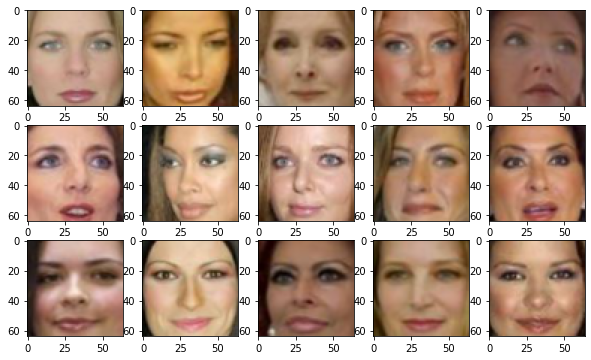

In [ ]:
#vibo: 15 фотографий без улыбок
fig=plt.figure(figsize=(10, 6))
columns = 5
rows = 3
for i in range(1, columns*rows +1):
    img = data[sad_photos][i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [ ]:
#vibo: данные в тензорах pytorch
sad_photos = data[sad_photos]
sad_photos.shape

torch.Size([15, 64, 64, 3])

In [ ]:
#vibo: латентное представление грустных
out = autoencoder.flatten(sad_photos.to(device)).float()
latent_code_sad = autoencoder.encoder(out).view(-1, 1, dim_code)
latent_code_sad.shape

torch.Size([15, 1, 1024])

In [ ]:
#vibo: средний вектор грустных
mean_latent_code_sad = torch.mean(latent_code_sad, 0)
mean_latent_code_sad.shape

torch.Size([1, 1024])

In [ ]:
#vibo: вычисляем вектор улыбки (латентное представление улыбающихся - латентное представление грустных)
smile_vector = mean_latent_code_smile - mean_latent_code_sad
smile_vector.shape

torch.Size([1, 1024])

In [ ]:
#vibo: к латентному представлению грустных людей (latent_code_sad) прибавляем вектов улыбки (smile_vector)
new_out = latent_code_sad + smile_vector
new_out.shape

torch.Size([15, 1, 1024])

In [ ]:
#vibo: походим через декодер
output = autoencoder.decoder(new_out.to(device))
output = output.view(-1, 64, 64, 3)
output = output.cpu().detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


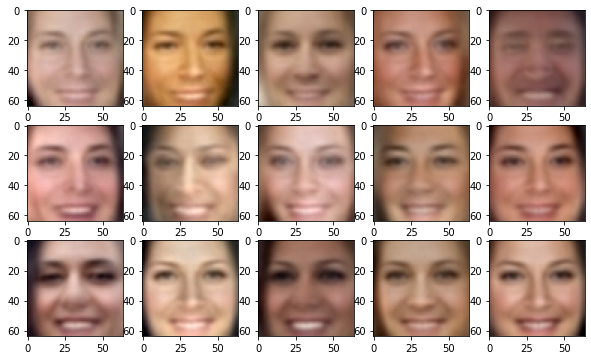

In [ ]:
fig=plt.figure(figsize=(10, 6))
columns = 5
rows = 3
for i in range(1, columns*rows +1):
    img = output[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
import torch.utils.data
import torchvision
from torchvision import transforms

batch_size = 32
# MNIST Dataset
train_dataset = torchvision.datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist_data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./mnist_data/
    Split: Test
    StandardTransform
Transform: ToTensor()

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
features = 16

class VAE(nn.Module):
    def __init__(self):
        '''
        <определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста", 
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        '''
        super(VAE, self).__init__()
        
        self.flatten = nn.Flatten()

        #vibo: encoder 
        self.fc1 = nn.Linear(28*28*1, 400) 
        self.relu = nn.ReLU() 
        #vibo: выход mu
        self.fc21 = nn.Linear(400, 20) 
        #vibo: выход для logsigma
        self.fc22 = nn.Linear(400, 20)
        
        #vibo: decoder
        self.fc3 = nn.Linear(20, 400) 
        self.fc4 = nn.Linear(400, 28*28*1) 
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        '''
        <реализуйте forward проход энкодера
        в качестве ваозвращаемых переменных -- mu и logsigma>
        '''
        #vibo: проходим через encoder
        h1 = self.relu(self.fc1(x))
        mu = self.fc21(h1)
        logsigma = self.fc22(h1)
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            #<засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            #vibo:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            #vibo:

            return mu
    
    def decode(self, z):
        '''
        <реализуйте forward проход декодера
        в качестве возвращаемой переменной -- reconstruction>
        '''
        #vibo: проходим через decoder
        h3 = self.relu(self.fc3(z))
        reconstruction = self.sigmoid(self.fc4(h3)) 
        return reconstruction

    def forward(self, x):
        '''
        <используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        '''
        #vibo:
        x = self.flatten(x).float()
        mu, logsigma = self.encode(x.view(-1, 784))
        z = self.gaussian_sampler(mu, logsigma) 
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

In [ ]:
#vibo: перенос на GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
#vibo: проверяем модель
autoencoder = VAE().to(device)
summary(autoencoder, input_size=(1, 28, 28))

TypeError: ignored

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp()) #<напишите код для KL-дивергенции, пользуясь формулой выше>
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum') #<binary cross-entropy>
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction) #<соедините тут две компоненты лосса. Mind the sign!>

И обучим модель:

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

criterion = loss_vae

autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=3e-4) #<Ваш любимый оптимизатор>

In [ ]:
#<обучите модель на датасете MNIST>

#vibo: реализуем цикл обучения вариационного автоэнкодера
n_epochs = 20
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for train_batch in train_loader:
        optimizer.zero_grad()
        train_reconstruction, train_latent_code = autoencoder(train_batch.to(device))
        train_reconstruction = train_reconstruction.view(-1, 64, 64, 3)
        train_loss = criterion(train_batch.to(device).float(), train_reconstruction)
        train_loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(train_loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for val_batch in val_loader: 
          val_reconstruction, val_latent_code = autoencoder(val_batch.to(device))
          val_reconstruction = val_reconstruction.view(-1, 64, 64, 3)
          val_loss = criterion(val_batch.to(device).float(), val_reconstruction)
          val_losses_per_epoch.append(val_loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

    #vibo: визуализируем loss
    clear_output(wait=True)
    plt.figure(figsize=(10, 7))
    plt.plot(np.arange(len(train_losses)), train_losses, label='train_losses')
    plt.plot(np.arange(len(val_losses)), val_losses, label='val_losses')

    plt.xlabel('Epoch')
    plt.title('MSE loss')
    plt.legend()
    plt.show()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
#< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
autoencoder.eval()
with torch.no_grad():
    for val_batch in val_loader:
      val_reconstruction, val_latent_code = autoencoder(val_batch.to(device))
      val_reconstruction = val_reconstruction.view(-1, 64, 64, 3)
      result = val_reconstruction.cpu().detach().numpy()
      ground_truth = val_batch.numpy()
      break

In [ ]:
plt.figure(figsize=(10, 4))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(2, 5, i+1)
  plt.imshow(gt)
  plt.subplot(2, 5, i+6)
  plt.imshow(res)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 100) for i in range(10)])
output = <скормите z декодеру>
<выведите тут полученные картинки>

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
<ваш код получения латентных представлений, применения TSNE и визуализации>

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
class CVAE(nn.Module):
    def __init__(self):
        <определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста", 
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>

    def encode(self, x, class_num):
        <реализуйте forward проход энкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и класс картинки>
        
        return mu, logsigma, class_num
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z, class_num):
        <реализуйте forward проход декодера
        в качестве возвращаемой переменной -- reconstruction>
        
        return reconstruction

    def forward(self, x):
        <используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        return mu, logsigma, reconstruction

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
<тут нужно научиться сэмплировать из декодера цифры определенного класса>

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
<ваш код получения латентных представлений, применения TSNE и визуализации>

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>